In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')

In [209]:
from astropy import constants as const
from astropy import units as u
import spin_models as spin
import scipy.stats as st

Notebook to generate the plot comparing the binary kick velocities to the triple slingshot velocity 

In [109]:
Binary_filename = "/Users/pranavsatheesh/Triples/Github/Illustris_Data/iso_binaries_data_from_ill.csv"
triple_filename = "/Users/pranavsatheesh/Triples/Github/Triple-Outcomes/Data/Triple_outcomes_N_100.csv"

### Binary Kick Velocities

In [112]:
df_binary = pd.read_csv(Binary_filename,index_col= False)
df_binary.head()
M1 = df_binary["M1"].to_numpy()
M2 = df_binary["M2"].to_numpy()

,M1,M2,qin,t_merger,z_merger,merger_flag
0,2.260508e+06,1.628522e+06,0.720423,8.585867e+08,6.460270,Yes
1,1.614294e+06,1.077030e+06,0.667183,8.924214e+08,6.270490,Yes
2,6.552913e+06,1.175374e+06,0.179367,3.833599e+09,1.720798,Yes
3,7.037528e+06,6.261750e+06,0.889766,1.653894e+11,0.000000,No
4,1.178789e+07,3.305567e+06,0.280421,1.484220e+10,0.000000,No


In [114]:
def find_q(M1,M2):
    if (M2>M1):
        q = M1/M2
    else:
        q = M2/M1
    
    return q

def kick_vel_for_a_spin_model(model,M1,M2,angle_arg_ret = "No"):

    a1 = []
    theta1 = []
    a2 = []
    theta2 = []
    recoil = []

    for i in range(len(M1)):

        S1,S2 = model()
        a1.append(np.linalg.norm(S1))
        a2.append(np.linalg.norm(S2))

        theta1.append(np.arccos(S1[2]/np.linalg.norm(S1)))
        theta2.append(np.arccos(S2[2]/np.linalg.norm(S2)))
        
        q_i = find_q(M1[i],M2[i])
        Vk = spin.gw_kick(q_i,S1,S2)

        recoil.append(np.linalg.norm(Vk))

    if angle_arg_ret == "Yes":
        return recoil,a1,theta1,theta2,recoil
    else:
        return recoil

In [115]:

V_rd = kick_vel_for_a_spin_model(spin.random_dry,M1,M2,angle_arg_ret = "No")
V_cold = kick_vel_for_a_spin_model(spin.cold,M1,M2,angle_arg_ret = "No")
V_deg5 = kick_vel_for_a_spin_model(spin.deg5_high,M1,M2,angle_arg_ret = "No")

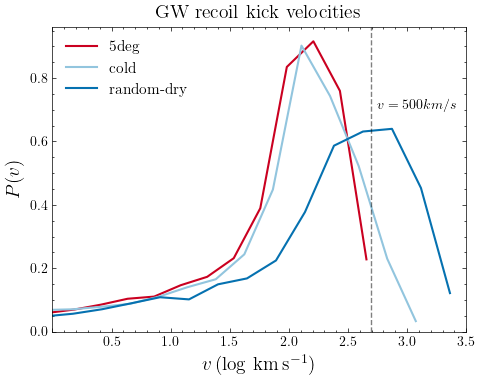

In [116]:
plt.figure(figsize=[5,4])

bin_heights, bin_borders = np.histogram(np.log10(V_deg5),bins=30,density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.plot(bin_centers,bin_heights,color="#ca0020",lw=1.5,label="5deg")

bin_heights, bin_borders = np.histogram(np.log10(V_cold),bins=30,density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.plot(bin_centers,bin_heights,color="#92c5de",lw=1.5,label="cold")


bin_heights, bin_borders = np.histogram(np.log10(V_rd),bins=30,density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.plot(bin_centers,bin_heights,color="#0571b0",lw=1.5,label="random-dry")

plt.axvline(x = np.log10(500),color = "k",linestyle = "--",alpha=0.5)

plt.text(np.log10(500)+0.05,0.7,'$v = 500 km/s$')

plt.xlim(0,3.5)
plt.ylim(0,)
plt.legend(fontsize=11)
plt.xlabel(r"$v \, (\log \, \text{km} \, \text{s}^{-1}$)",fontsize=14)
plt.ylabel(r"$P(v)$",fontsize=14)

ax = plt.gca()
xticks = ax.xaxis.get_major_ticks()
xticks[0].label1.set_visible(False)

plt.title("GW recoil kick velocities",fontsize=14)
plt.tight_layout()

### Slingshot Velocity 

In [202]:
df_trip = pd.read_csv(triple_filename,index_col=False)
df_trip = df_trip[520:2*520]
df_trip.head()
#cases where you have an ejection
df_trip_esc = df_trip[(df_trip["merger_flag"]=="No")|(df_trip["merger_flag"]=="Tr-ej")]


In [119]:
#hardening radius
def a_hard(M1,qin):
    ahard = 0.80 * (4*qin)/(1+qin)**2 * ((M1.value*(1+qin))/10**8)**(1/2)
    return ahard

In [206]:
# # calculate slingshot velocity for the scatter case
# def v_trip_cal(m1,qin,qout,a_ovtks):
    
#     f = 0.4
#     m1 = m1 * u.M_sun

#     ahard = a_hard(m1,qin)

#     if(ahard<a_ovtks):
#         a_t = ahard
#     else:
#         a_t = a_ovtks

#     a_t = a_t * u.pc
#     Vsling = np.sqrt(f*const.G * (m1.to(u.kg) * qin)/((a_t).to(u.m) *(1+qout) * (1+qin) )).to(u.km * u.s**-1) #km/s
#     return Vsling.value


In [207]:
# calculate dE for the scatter case
def dE_scatter(m1,m2,m3,a_t):

    a_t = a_t * u.pc
    m1 = m1 * u.M_sun
    m2 = m2 * u.M_sun
    m3 = m3 * u.M_sun

    qout = m3/(m1+m2)
    #qout = m3/m2
    Eb = const.G * m1.to(u.kg) * m2.to(u.kg)/(2* a_t.to(u.m))

    f= 0.4
    #f=0.7

    return f*Eb*qout

In [208]:
# calculate dE for the exchange 
def dE_exchange(m1,m2,m3,a_t):

    
    #a_t = a_t * (m3/m2) * u.pc
    a_t = a_t * u.pc
    m1 = m1 * u.M_sun
    m2 = m2 * u.M_sun
    m3 = m3 *u.M_sun

    BE_i = const.G*(m1.to(u.kg)*m2.to(u.kg))/(2*a_t.to(u.m))

    BE_f = const.G*(m1.to(u.kg)*m3.to(u.kg))/(2*a_t.to(u.m))

    DE = BE_f - BE_i
    
    return DE

    # qout = m2/(m1+m3)
    # Eb = const.G * m1.to(u.kg) * m2.to(u.kg)/(2* a_t.to(u.m))

    # f= 0.4

    # return f*Eb*qout


In [125]:
#calculate slingshot velocity for both scatter and exchange case indicated by the 'exchange' argument
def v_trip_cal(m1,m2,m3,a_ovtks,exchange=0):
    
    qin = m2/m1
    qout = m3/(m1+m2)
    ahard = a_hard(m1* u.M_sun,qin)

    if(ahard<a_ovtks):
        at = ahard
    else:
        at = a_ovtks

    if(exchange == 1):
        dEb = dE_exchange(m1,m2,m3,at)
        qout = m2/(m1+m3)
        m2 = m2 *u.M_sun
        V = np.sqrt(2*dEb/(m2.to(u.kg) * (1+qout))).to(u.km * u.s**-1)

    
    else:
        
        qout = m3/(m1+m2)
        dEb = dE_scatter(m1,m2,m3,at)
        m3 = m3 * u.M_sun
        V = np.sqrt(2*dEb/(m3.to(u.kg) * (1+qout))).to(u.km * u.s**-1)

    return V.value

In [126]:
vesc=[]
for i in range(len(df_trip_esc)):
    m1 = df_trip_esc["M1"].iloc[i]
    m2 = df_trip_esc["M2"].iloc[i]
    m3 = df_trip_esc["M3"].iloc[i]
    qin = df_trip_esc["qin"].iloc[i]
    qout = df_trip_esc["qout"].iloc[i]
    atrip = df_trip_esc["a_triple"].iloc[i]

    if((m3<m1)&(m3<m2)):
        vesc.append(v_trip_cal(m1,m2,m3,atrip))
    else:
        vesc.append(v_trip_cal(m1,m2,m3,atrip,exchange=1))

In [127]:
def fit_norm(x,mu,sigma):
    return st.norm.pdf(x,mu,sigma)

In [146]:
v_max = 5
v_min = 1
v_binsize = 0.14
bincounts,binedges = np.histogram(np.log10(vesc),range=(v_min,v_max),bins=int((v_max-v_min)/v_binsize),density=True)
bins = binedges[:-1] + (binedges[1] - binedges[0])/2

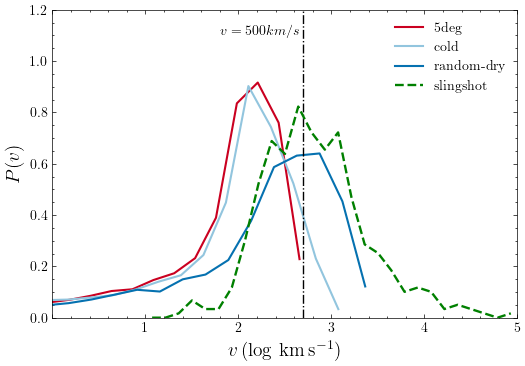

In [210]:
params=[2.87678065,0.31454837]
plt.figure(figsize=[6,4])
#plt.plot(bins,fit_norm(bins,params[0],params[1]),label="Hoffman \& Loeb(2007)")

bin_heights, bin_borders = np.histogram(np.log10(V_deg5),bins=30,density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.plot(bin_centers,bin_heights,color="#ca0020",lw=1.5,label="5deg")

bin_heights, bin_borders = np.histogram(np.log10(V_cold),bins=30,density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.plot(bin_centers,bin_heights,color="#92c5de",lw=1.5,label="cold")

bin_heights, bin_borders = np.histogram(np.log10(V_rd),bins=30,density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.plot(bin_centers,bin_heights,color="#0571b0",lw=1.5,label="random-dry")

plt.xlim(0,5)
plt.ylim(0,1.2)

plt.axvline(np.log10(500),linestyle="-.",color="k")

plt.plot(bins,bincounts,color="green",lw=1.7,linestyle="--",label="slingshot")

plt.legend(fontsize=11)
plt.xlabel(r"$v \, (\log \, \text{km} \, \text{s}^{-1}$)",fontsize=14)
plt.ylabel(r"$P(v)$",fontsize=14)
plt.legend()

ax = plt.gca()
xticks = ax.xaxis.get_major_ticks()
xticks[0].label1.set_visible(False)
plt.text(np.log10(500)-0.9,1.1,'$v = 500 km/s$')
plt.savefig("Figures/binary-kick-vs-triple-kick-velocities.pdf")

1. $m_3<(m_1,m_2)$ : $\Delta E = 0.4 E_b (m_3/(m_1 + m_2))$
2. $m_3 > m_2$ : $\Delta E = Eb_f - Eb_i$

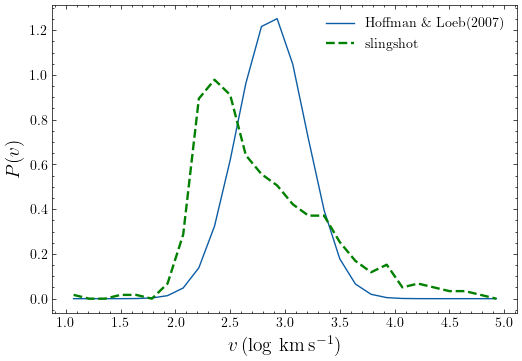

In [172]:
params=[2.87678065,0.31454837]
plt.figure(figsize=[6,4])
plt.plot(bins,fit_norm(bins,params[0],params[1]),label="Hoffman \& Loeb(2007)")
plt.plot(bins,bincounts,color="green",lw=1.7,linestyle="--",label="slingshot")

plt.legend(fontsize=11)
plt.xlabel(r"$v \, (\log \, \text{km} \, \text{s}^{-1}$)",fontsize=14)
plt.ylabel(r"$P(v)$",fontsize=14)
plt.legend()


In [197]:
def dE_scatter(m1,m2,m3,a_t):

    a_t = a_t * u.pc
    m1 = m1 * u.M_sun
    m2 = m2 * u.M_sun
    m3 = m3 * u.M_sun

    qout = m3/(m1+m2)
    #qout = m3/m2
    Eb = const.G * m1.to(u.kg) * m2.to(u.kg)/(2* a_t.to(u.m))

    f= 0.4
    #f=0.7

    return f*Eb


def dE_exchange(m1,m2,m3,a_t):

    
    #a_t = a_t * (m3/m2) * u.pc
    a_t = a_t * u.pc
    m1 = m1 * u.M_sun
    m2 = m2 * u.M_sun
    m3 = m3 *u.M_sun

    BE_i = const.G*(m1.to(u.kg)*m2.to(u.kg))/(2*a_t.to(u.m))

    BE_f = const.G*(m1.to(u.kg)*m3.to(u.kg))/(2*a_t.to(u.m))

    DE = BE_f - BE_i
    
    return DE

    # qout = m2/(m1+m3)
    # Eb = const.G * m1.to(u.kg) * m2.to(u.kg)/(2* a_t.to(u.m))

    # f= 0.4

    # return f*Eb*qout

vesc=[]
for i in range(len(df_trip_esc)):
    m1 = df_trip_esc["M1"].iloc[i]
    m2 = df_trip_esc["M2"].iloc[i]
    m3 = df_trip_esc["M3"].iloc[i]
    qin = df_trip_esc["qin"].iloc[i]
    qout = df_trip_esc["qout"].iloc[i]
    atrip = df_trip_esc["a_triple"].iloc[i]

    if((m3<m1)&(m3<m2)):
        vesc.append(v_trip_cal(m1,m2,m3,atrip))
    else:
        vesc.append(v_trip_cal(m1,m2,m3,atrip,exchange=1))

        
        
v_max = 5
v_min = 1
v_binsize = 0.14
bincounts,binedges = np.histogram(np.log10(vesc),range=(v_min,v_max),bins=int((v_max-v_min)/v_binsize),density=True)
bins = binedges[:-1] + (binedges[1] - binedges[0])/2


1. $m_3<(m_1,m_2)$ : $\Delta E = 0.4 E_b$
2. $m_3 > m_2$ : $\Delta E = Eb_f - Eb_i$

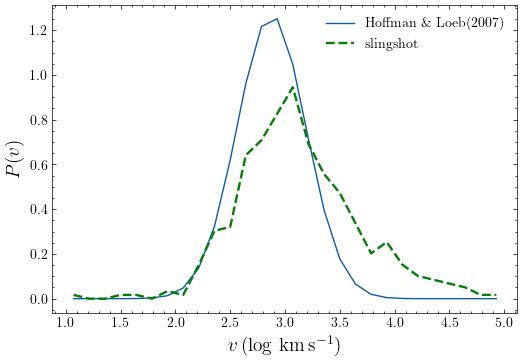

In [198]:
params=[2.87678065,0.31454837]
plt.figure(figsize=[6,4])
plt.plot(bins,fit_norm(bins,params[0],params[1]),label="Hoffman \& Loeb(2007)")
plt.plot(bins,bincounts,color="green",lw=1.7,linestyle="--",label="slingshot")

plt.legend(fontsize=11)
plt.xlabel(r"$v \, (\log \, \text{km} \, \text{s}^{-1}$)",fontsize=14)
plt.ylabel(r"$P(v)$",fontsize=14)
plt.legend()

In [200]:
def dE_scatter(m1,m2,m3,a_t):

    a_t = a_t * u.pc
    m1 = m1 * u.M_sun
    m2 = m2 * u.M_sun
    m3 = m3 * u.M_sun

    qout = m3/(m1+m2)
    #qout = m3/m2
    Eb = const.G * m1.to(u.kg) * m2.to(u.kg)/(2* a_t.to(u.m))

    f= 0.4
    #f=0.7

    return f*Eb


def dE_exchange(m1,m2,m3,a_t):

    
    a_t = a_t * (m3/m2) * u.pc
    # a_t = a_t * u.pc
    m1 = m1 * u.M_sun
    m2 = m2 * u.M_sun
    m3 = m3 *u.M_sun

    # BE_i = const.G*(m1.to(u.kg)*m2.to(u.kg))/(2*a_t.to(u.m))

    # BE_f = const.G*(m1.to(u.kg)*m3.to(u.kg))/(2*a_t.to(u.m))

    # DE = BE_f - BE_i
    
    # return DE

    qout = m2/(m1+m3)
    Eb = const.G * m1.to(u.kg) * m2.to(u.kg)/(2* a_t.to(u.m))

    f= 0.4

    return f*Eb

vesc=[]
for i in range(len(df_trip_esc)):
    m1 = df_trip_esc["M1"].iloc[i]
    m2 = df_trip_esc["M2"].iloc[i]
    m3 = df_trip_esc["M3"].iloc[i]
    qin = df_trip_esc["qin"].iloc[i]
    qout = df_trip_esc["qout"].iloc[i]
    atrip = df_trip_esc["a_triple"].iloc[i]

    if((m3<m1)&(m3<m2)):
        vesc.append(v_trip_cal(m1,m2,m3,atrip))
    else:
        vesc.append(v_trip_cal(m1,m2,m3,atrip,exchange=1))

        
        
v_max = 5
v_min = 1
v_binsize = 0.14
bincounts,binedges = np.histogram(np.log10(vesc),range=(v_min,v_max),bins=int((v_max-v_min)/v_binsize),density=True)
bins = binedges[:-1] + (binedges[1] - binedges[0])/2


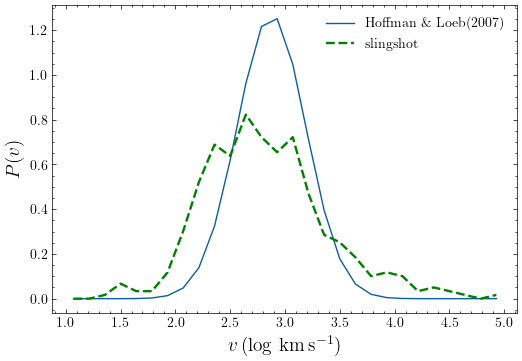

In [201]:
params=[2.87678065,0.31454837]
plt.figure(figsize=[6,4])
plt.plot(bins,fit_norm(bins,params[0],params[1]),label="Hoffman \& Loeb(2007)")
plt.plot(bins,bincounts,color="green",lw=1.7,linestyle="--",label="slingshot")

plt.legend(fontsize=11)
plt.xlabel(r"$v \, (\log \, \text{km} \, \text{s}^{-1}$)",fontsize=14)
plt.ylabel(r"$P(v)$",fontsize=14)
plt.legend()